In [14]:
import numpy as np

#plotting
import matplotlib.pyplot as plt

In [15]:
#import matplotlib.style as style
#style.use("grayscale")
%matplotlib inline

#units
from astropy import units as u

#POPPY
import poppy
import sys
from poppy import fresnel


from poppy.poppy_core import _PUPIL, _IMAGE, _INTERMED

#logging
import logging
_log = logging.getLogger('poppy')
_log.setLevel(logging.DEBUG)

#make logging work in IPYTHON:
try:
    from IPython.core.debugger import Tracer; stop = Tracer()
except:
    pass

logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.DEBUG, datefmt='%I:%M:%S')

In [16]:
class sinc_squared_occulter(poppy.AnalyticOpticalElement):

    def __init__(self, name='occulter', **kwargs):
        poppy.AnalyticOpticalElement.__init__(self, name=name, **kwargs)

    def getPhasor(self, wave):
        y, x = wave.coordinates()
        r = np.sqrt(x ** 2 + y ** 2)
        theta = np.arctan2(y,x)
        amp = 1 - (np.sinc(r))**2
        return amp

In [17]:
class aberation_inducer(poppy.AnalyticOpticalElement):

    def __init__(self, name=None, radius=1.0, pad_factor=1.0, **kwargs):
        try:
            self.radius = float(radius)
        except ValueError:
            raise TypeError("Argument 'radius' must be the radius of the pupil in meters")
            
        if name is None:
            name = "Circle, radius=%.2f m" % radius
        super(aberation_inducer, self).__init__( name=name, planetype=_PUPIL, **kwargs)
        # for creating input wavefronts - let's pad a bit:
        self.pupil_diam = pad_factor * 2 * self.radius

    def __load_aberation_map_interpolator__(self,radius):
        from scipy.interpolate import InterpolatedUnivariateSpline
        dataFile = 'new_circular_error_map.dat'
        fd = open(dataFile,'rb')
        fd.seek(0,0)
        nmap = np.fromfile(fd, dtype = np.long, count = 1)[0]
        fd.seek(4,0)
        rmap = np.fromfile(fd, dtype = np.float64, count = nmap) * radius
        zmap = np.fromfile(fd, dtype = np.float64, count = nmap)
        fd.close()
        f = InterpolatedUnivariateSpline(rmap, zmap, k=4)
        return f
    
    def getPhasor(self, wave):
        if not isinstance(wave, poppy.Wavefront):  # pragma: no cover
            raise ValueError("CircularAperture getPhasor must be called with a Wavefront "
                             "to define the spacing")
        assert (wave.planetype != _IMAGE)
        
        propper_sampling = 0.0000813802050996

        y, x = self.get_coordinates(wave)
        r = np.sqrt(x ** 2 + y ** 2)*(propper_sampling/wave.pixelscale)
        del x
        del y
        interpolator = self.__load_aberation_map_interpolator__(self.radius)
        self.aberation_map = interpolator(r)
        w_outside = np.where(r > self.radius)
        del r
        self.transmission = np.ones(wave.shape) + np.exp(1.j * 2 * np.pi * self.aberation_map)
        self.transmission[w_outside] = 0
        return self.transmission

In [18]:
def poppy_cor(wavefront,use_occulter=True):
    
    diam = 0.025*u.m
    fl = 0.7*u.m
    
    #Ref Figure 9
    wavefront *= poppy.CircularAperture(radius=diam.value/2.0)
    wavefront *= aberation_inducer(radius=diam.value/2.0);
    wavefront.apply_lens_power(fresnel.GaussianLens(fl, name='M1'))
    wavefront *= poppy.CircularAperture(radius=diam.value/2.0)
    
    wavefront.propagate_fresnel(fl,display_intermed=False)

    if (use_occulter): wavefront *= sinc_squared_occulter()
    wavefront *= poppy.CircularAperture(radius=250.0/wavefront.pixelscale)
    
    wavefront.propagate_fresnel(fl,display_intermed=False)

    wavefront.apply_lens_power(fresnel.GaussianLens(fl, name='M2'))
    wavefront *= poppy.CircularAperture(radius=diam.value/2 * 1.6)

    wavefront.propagate_fresnel(2*fl,display_intermed=False)

    wavefront.planetype = _PUPIL
    wavefront *= poppy.CircularAperture(radius=diam.value/2 * 0.53)
    
    wavefront.apply_lens_power(fresnel.GaussianLens(fl, name='Lyot stop'))

    wavefront.propagate_fresnel(fl,display_intermed=False)
    
    return wavefront

In [19]:
#Using the same simple setup used in TDEM milestone 1 report, Appendix B: Verification of PROPER (p. 26)
#Ref Figure 9 for the setup, Ref p. 27 for dimensions


lam = 500e-9

osamp=1 #oversampling factor

n=2048

#intialize wavefront
poppy_wavefront = fresnel.FresnelWavefront(0.025*u.m, wavelength=lam, npix=n, oversample=osamp)

poppy_field = poppy_cor(poppy_wavefront,use_occulter=True)
poppy_psf = poppy_cor(poppy_wavefront,use_occulter=False)

DEBUG:poppy:Skipping oversampling, oversample < 1 or already padded 
DEBUG:poppy:  Multiplied WF by phasor for Pupil plane: Circle, radius=0.01 m (Analytic)
DEBUG:poppy:  Multiplied WF by phasor for Pupil plane: Circle, radius=0.01 m (Analytic)
DEBUG:poppy:Initialized: M1, fl =7.00e-01 m
DEBUG:poppy:------ Applying Lens: M1 ------
DEBUG:poppy:  Pre-Lens Beam Parameters: w_0:2.500e-02 m, z_w0=0.000e+00 m
z=0.000e+00 m, z_R=3.927e+03 m
DEBUG:poppy:  Beam radius at M1 =2.50e-02 m
DEBUG:poppy: input flat wavefront and M1 has output beam curvature of =-7.00e-01 m
DEBUG:poppy:M1 has a curvature of =-7.00e-01 m
DEBUG:poppy:M1 has a curved output wavefront, with waist at 0.699999977758 m
DEBUG:poppy:Post Optic Parameters:w_0:4.456e-06 m, z_w0=7.000e-01 m
z=0.000e+00 m, z_R=1.248e-04 m
DEBUG:poppy:Set output beam focal length to 0.7 m
DEBUG:poppy:Inside Rayleigh distance to Outside Rayleigh distance.
DEBUG:poppy:Applying spherical phase curvature =2.20e+07 m
DEBUG:poppy:Applying spherical lens 

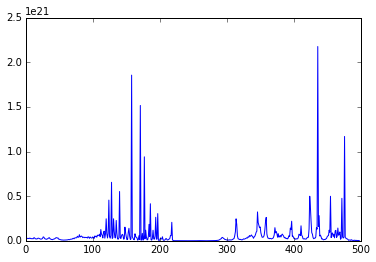

In [11]:
poppy_field_profile = poppy_field.wavefront[n/2:n/2+499,n/2]
poppy_psf_profile = poppy_field.intensity[n/2:n/2+499,n/2]
poppy_contrast_profile = poppy_field_profile / poppy_psf_profile

plt.plot(np.square(np.abs(poppy_contrast_profile)))